# Template for Depression Detection
Artificial Intelligence, 2024



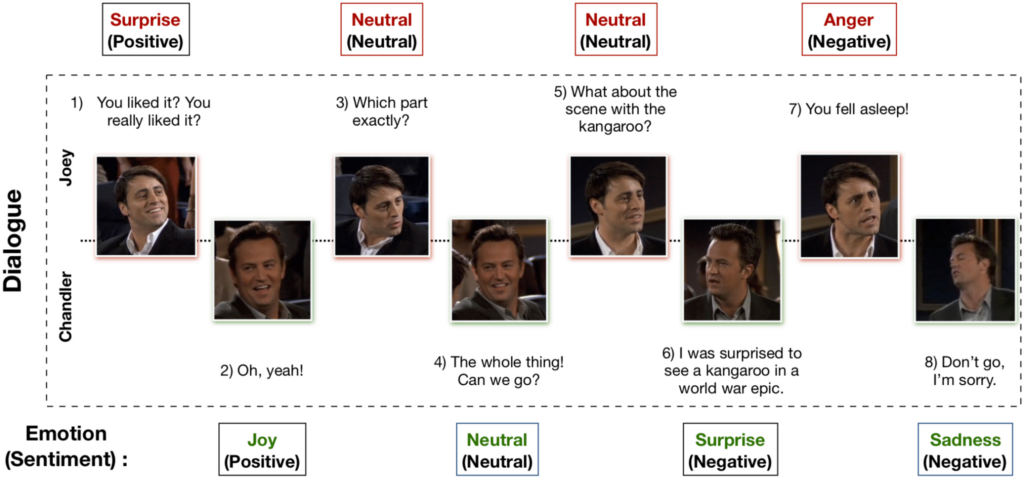

1. You can find data here, but we provided codes to load dataset.  
https://github.com/declare-lab/MELD

2. You can choose data to use. For example, you can use only utterance, or video frame and utterance.  
   Of course, only video frame is okay.
   If you are not familiar to signal data, I recommend you to study Fourier transform, time series analysis, etc...

In [1]:
# Download Dataset
!wget https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz

# Unzip Data
!tar -xf MELD.Raw.tar.gz

# Unzip Train data
!tar -xf ./MELD.Raw/train.tar.gz
# Unzip Valid data
!tar -xf ./MELD.Raw/dev.tar.gz
# Unzip Test data
!tar -xf ./MELD.Raw/test.tar.gz

--2024-04-27 13:29:41--  https://web.eecs.umich.edu/~mihalcea/downloads/MELD.Raw.tar.gz
web.eecs.umich.edu (web.eecs.umich.edu) 해석 중... 141.212.113.214
다음으로 연결 중: web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 10878146150 (10G) [application/x-gzip]
저장 위치: `MELD.Raw.tar.gz'

MELD.Raw.tar.gz     100%[===================>]  10.13G  2.17MB/s    /  2h 2m   

2024-04-27 15:32:23 (1.41 MB/s) - `MELD.Raw.tar.gz' 저장함 [10878146150/10878146150]



In [166]:
import torch
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms
from torchvision.io import read_video
from torchaudio.transforms import Resample
from torch.utils.data import DataLoader, Dataset
from moviepy.editor import VideoFileClip, AudioFileClip

In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchaudio

class MELDDataset(Dataset):
    def __init__(self, root_dir, transcripts_file, transform=None):
        self.root_dir = root_dir
        self.transcripts_df = pd.read_csv(transcripts_file)
        self.transform = transform

    def __len__(self):
        return len(self.transcripts_df)

    def __getitem__(self, idx):
        transcript_row = self.transcripts_df.iloc[idx]
        text = transcript_row['Utterance']
        audio_file = os.path.join(self.root_dir, 'audio', transcript_row['Dialogue_ID'] + '.wav')
        image_file = os.path.join(self.root_dir, 'images', transcript_row['Dialogue_ID'], transcript_row['Utterance_ID'] + '.jpg')

        audio, _ = torchaudio.load(audio_file)
        image = Image.open(image_file).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return text, audio, image

# Example usage
root_dir = 'path/to/MELD'
transcripts_file = 'path/to/MELD/transcripts.csv'

# Define transformations if needed
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create dataset instance
dataset = MELDDataset(root_dir, transcripts_file, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Iterate over batches
for texts, audios, images in dataloader:
    # texts: Batch of textual data
    # audios: Batch of audio data
    # images: Batch of image data
    pass  # Do something with the batches


In [308]:
# Load Dataset
# resize_size is the size of sampled video. Default is 224. (which is 3*224*224)
# fps means sampling rate. Default is 1, which means capturing whole frame.
class MELD(Dataset):
    def __init__(self, 
                 video_dir, 
                 df_dir,
                 second=2, 
                 transform=None):
        self.video_dir = video_dir
        self.df = pd.read_csv(df_dir)
        self.second = second
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = 'dia' + str(self.df.iloc[idx]['Dialogue_ID']) + '_utt' + str(self.df.iloc[idx]['Utterance_ID']) + '.mp4'
        video_path = os.path.join(self.video_dir, filename)
        video, audio, _ = read_video(video_path, pts_unit='sec')    
        speed = self.speed / video.shape[0]
        sampled_frames = torch.nn.functional.interpolate(video.unsqueeze(0), size=(self.second,)+video.shape[1:], mode='linear').squeeze(0)
        sampled_frames = sampled_frames[:self.fps]
        sampled_audio = sampled_audio[:, :self.fps*44100]
        processed_frames = []

        for frame in sampled_frames:
            frame = transforms.functional.resize(frame.permute(2,0,1),size=(224,224))
            if self.transform:
                frame = self.transform(frame)
            processed_frames.append(frame)
        return processed_frames, self.df.iloc[idx]['Utterance'].replace('\x92', "'"), sampled_audio, self.df.iloc[idx]['Emotion']

In [ ]:
import torchaudio

In [309]:
# DataLoader
transform = None#transforms.Resize((224, 224, 3))#transforms.ToTensor()

train_data = MELD('./train_splits', './train_sent_emo.csv', transform=transform)
valid_data = MELD('./dev_splits_complete', './MELD.Raw/dev_sent_emo.csv', transform=transform)
test_data = MELD('./output_repeated_splits_test', './MELD.Raw/test_sent_emo.csv', transform=transform)

train_loader = DataLoader(train_data, batch_size=2)
valod_loader = DataLoader(valid_data, batch_size=1)
test_loader = DataLoader(test_data, batch_size=1)

In [310]:
# Data preview.
# Data loader returns: video frame, utterance, audio wave, and emotion(label).
it = iter(train_loader)

In [311]:
vid_frame, utterance, audio, emotion = next(it)
f = 1
plt.figure(dpi=500)
for i in range(0, len(vid_frame), 5):
    try:
        plt.subplot(1, 6, f)
        plt.axis('off')
        plt.imshow(vid_frame[i][0].permute(1,2,0))#.permute(1,2,0))
        f += 1
    except:
        break
print(utterance)
print(emotion)

torch.Size([2, 272384])
torch.Size([2, 136192])
torch.Size([2, 70656])
torch.Size([2, 70656])


RuntimeError: stack expects each tensor to be equal size, but got [2, 136192] at entry 0 and [2, 141312] at entry 1

In [295]:
audio.shape

torch.Size([2, 2, 50])

In [294]:
import torch
from pydub import AudioSegment
from pydub.playback import play

# 오디오 텐서 (channel, samples)로 가정
audio_tensor = audio[0]

# 오디오 텐서를 wav 파일로 저장
sample_rate = 44100  # 샘플링 속도 설정 (예시)
audio_tensor = audio_tensor.numpy()  # 텐서를 넘파이 배열로 변환
audio_tensor = audio_tensor.T  # 텐서를 (samples, channel) 형식으로 전치
audio_tensor = audio_tensor.astype('int16')  # 16비트로 변환
torch_audio = AudioSegment(audio_tensor.tobytes(), frame_rate=sample_rate, sample_width=2, channels=audio_tensor.shape[1])

# 오디오 재생
play(torch_audio)


Input #0, wav, from '/var/folders/qb/01y_x1nx5jn6frq074vhfbc00000gn/T/tmp72d53pkr.wav':
  Duration: 00:00:00.00, bitrate: 1721 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [268]:
play(torch_audio)

Input #0, wav, from '/var/folders/qb/01y_x1nx5jn6frq074vhfbc00000gn/T/tmpq_47wx00.wav':
  Duration: 00:00:00.00, bitrate: 1721 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s


In [266]:
!pip install FFmpeg

ERROR: Could not find a version that satisfies the requirement ffplay (from versions: none)
ERROR: No matching distribution found for ffplay


In [261]:
audio.shape

torch.Size([2, 2, 50])

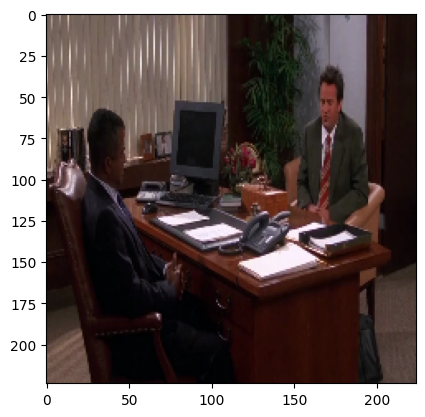

In [6]:
plt.imshow(vid_frame[0][0].permute(1,2,0))

In [12]:
import mediapipe as mp
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
  image = vid_frame[0][0].permute(1,2,0)
  # 작업 전에 BGR 이미지를 RGB로 변환합니다.
  results = face_detection.process(image)
  # 이미지를 출력하고 그 위에 얼굴 박스를 그립니다.
  annotated_image = image.copy()
  for detection in results.detections:
    print('Nose tip:')
    print(mp_face_detection.get_key_point(
    detection, mp_face_detection.FaceKeyPoint.NOSE_TIP))
    mp_drawing.draw_detection(annotated_image, detection)
    plt.imshow(annotated_image)

I0000 00:00:1715133478.207928       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1 Pro


AttributeError: 'Tensor' object has no attribute 'flags'

In [ ]:
i = 

In [ ]:
numpy_data = audio.numpy()
num_samples = numpy_data.shape[1]
time = torch.arange(0, num_samples) / 44100

plt.figure(figsize=(10, 4))
plt.plot(time, numpy_data[0, :, 0], label='Channel 1')
plt.plot(time, numpy_data[0, :, 1], label='Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Audio Waveform')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
# Data Label
df_train = pd.read_csv('./train_sent_emo.csv')
df_train['Utterance'] = df_train['Utterance'].str.replace('\x92', "'")
df_train

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my company's tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You must've had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So let's talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


In [39]:
color = sns.color_palette('pastel')

<Axes: >

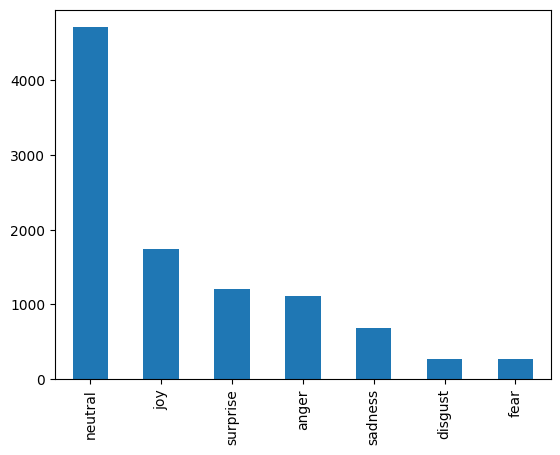

In [41]:
df_train['Emotion'].value_counts().plot(kind='bar')#, colormap=color)

<Axes: >

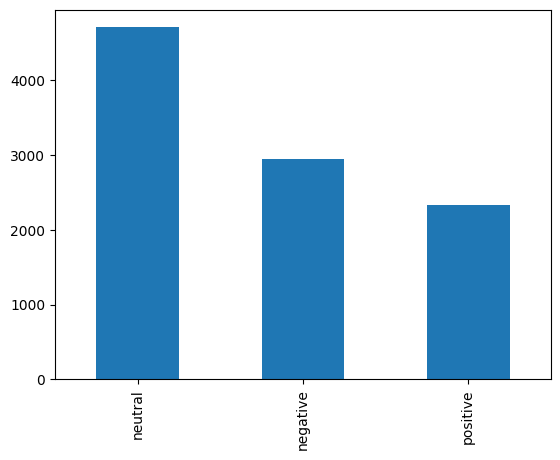

In [29]:
df_train['Sentiment'].value_counts().plot(kind='bar')

<Axes: >

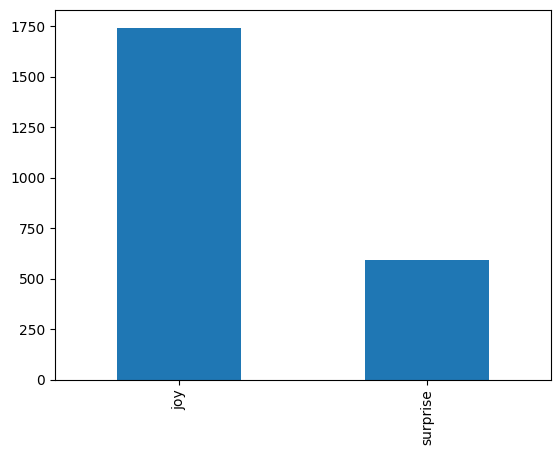

In [33]:
df_train[df_train['Sentiment']=='positive']['Emotion'].value_counts().plot(kind='bar')

<Axes: >

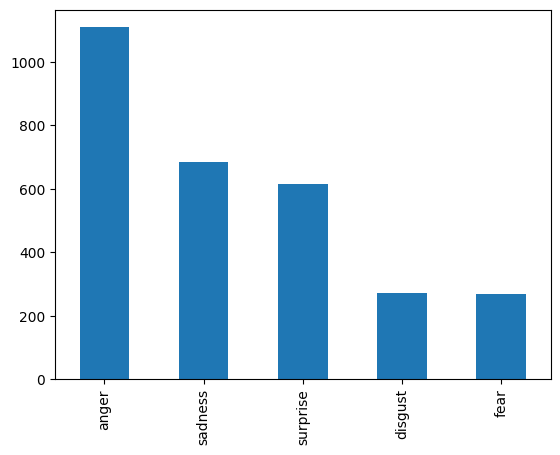

In [34]:
df_train[df_train['Sentiment']=='negative']['Emotion'].value_counts().plot(kind='bar')

<Axes: >

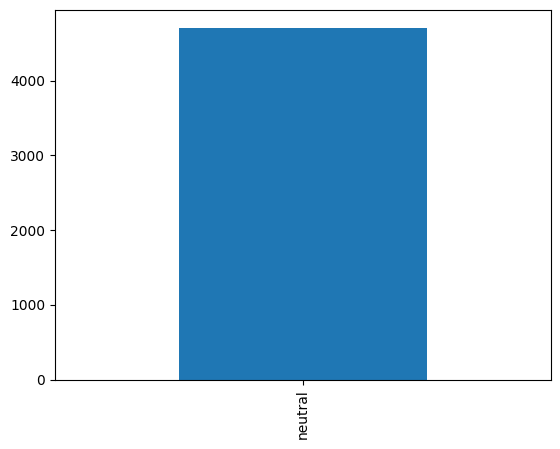

In [42]:
df_train[df_train['Sentiment']=='neutral']['Emotion'].value_counts().plot(kind='bar')